In [37]:
# Makine öğrenmesi, derin öğrenme ve veri analizi için temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Makine öğrenmesi modelleri ve metrikleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier

# Derin öğrenme için
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Uyarıları kapatmak için (isteğe bağlı)
import warnings
warnings.filterwarnings('ignore')

print("Tüm kütüphaneler başarıyla yüklendi!")


Tüm kütüphaneler başarıyla yüklendi!


In [38]:
import pandas as pd

df = pd.read_csv("rayl-sistemler-istasyon-bazl-yolcu-ve-yolculuk-saylar-2024.csv")
print(df.head())
print(df.info())


   transaction_year  transaction_month                        line  \
0              2024                  6      M1-YENIKAPI-HAVALIMANI   
1              2024                  2       TCDD TASIMACILIK A.S.   
2              2024                  2       TCDD TASIMACILIK A.S.   
3              2024                  3        M7-KABATAS-MAHMUTBEY   
4              2024                  4  M3-BASAKSEHIR-OLIMPIYATKOY   

       station_name station_number      town  longitude   latitude  \
0         Yenibosna        YBS-YBS  Bakırköy  28.837444  40.989694   
1        Yenikapı-2        YNK-MR2     Fatih  28.951611  41.005167   
2         Aydıntepe        AYD-MR1     Tuzla  29.293194  40.852694   
3       M7 YILDIZ 2        YLZ-YL2  Beşiktaş  29.008303  41.052433   
4  Kayaşehir Merkez        KYS-KYS  Bağcılar  28.767179  41.119717   

   passage_cnt  passanger_cnt  
0        58497          24746  
1      1714887         706794  
2       142298          50642  
3        66311          23481 

In [39]:
# 1. Gereksiz sütun var mı kontrol et
print(df.columns)

# 2. Eksik veri kontrolü
print(df.isnull().sum())

# 3. Kategorik değişkenleri LabelEncoder ile sayısala çevir (line, station_name, station_number, town)
categorical_cols = ['line', 'station_name', 'station_number', 'town']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# 4. Gerekirse longitude ve latitude bırakılabilir (modelde etkili olabilir)
# 5. Hedef değişkeni (busy_station) oluştur: ortalamanın %70'i üstü YOĞUN (1), aksi halde AZ YOĞUN (0)
threshold = df['passanger_cnt'].mean() * 0.7
df['busy_station'] = (df['passanger_cnt'] > threshold).astype(int)

print(df[['passanger_cnt', 'busy_station']].head(10))
print(df['busy_station'].value_counts())


Index(['transaction_year', 'transaction_month', 'line', 'station_name',
       'station_number', 'town', 'longitude', 'latitude', 'passage_cnt',
       'passanger_cnt'],
      dtype='object')
transaction_year       0
transaction_month      0
line                   0
station_name          25
station_number        25
town                 337
longitude            638
latitude             638
passage_cnt            0
passanger_cnt          0
dtype: int64
   passanger_cnt  busy_station
0          24746             0
1         706794             1
2          50642             0
3          23481             0
4          52498             0
5         196843             1
6          34806             0
7          46788             0
8          50956             0
9         248848             1
busy_station
0    1919
1    1862
Name: count, dtype: int64


In [40]:
# Özellik sütunları (hedef ve kimlik sütunları hariç)
features = ['transaction_year', 'transaction_month', 'line', 'station_name',
            'station_number', 'town', 'longitude', 'latitude', 'passage_cnt']

X = df[features]
y = df['busy_station']

# Sayısal verileri standartlaştır (özellikle DL için önemli)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim ve test verisine ayır (test_size=0.2 yani %20 test, %80 eğitim)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (3024, 9)
X_test shape: (757, 9)


In [41]:
# Random Forest Classifier ile model kur, eğit ve test et
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahminleri al
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # ROC-AUC için

# Skorları hesapla
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Scores:")
print(f"Accuracy: {rf_acc:.3f}")
print(f"Precision: {rf_prec:.3f}")
print(f"Recall: {rf_rec:.3f}")
print(f"F1 Score: {rf_f1:.3f}")
print(f"ROC-AUC: {rf_auc:.3f}")


Random Forest Scores:
Accuracy: 0.976
Precision: 0.986
Recall: 0.965
F1 Score: 0.976
ROC-AUC: 0.996


In [42]:
# Eksik değerleri ortalama ile doldur
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)   # Bu X'i standartize etmek için scale edeceğiz

# Tekrar bölüyoruz (çünkü X bir numpy array oldu)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Şimdi scale et
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

y_pred_lr = logreg_model.predict(X_test)
y_proba_lr = logreg_model.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr)
lr_rec = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression Scores:")
print(f"Accuracy: {lr_acc:.3f}")
print(f"Precision: {lr_prec:.3f}")
print(f"Recall: {lr_rec:.3f}")
print(f"F1 Score: {lr_f1:.3f}")
print(f"ROC-AUC: {lr_auc:.3f}")


Logistic Regression Scores:
Accuracy: 0.923
Precision: 0.925
Recall: 0.920
F1 Score: 0.922
ROC-AUC: 0.982


In [43]:
!pip install xgboost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_prec = precision_score(y_test, y_pred_xgb)
xgb_rec = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_proba_xgb)

print("XGBoost Scores:")
print(f"Accuracy: {xgb_acc:.3f}")
print(f"Precision: {xgb_prec:.3f}")
print(f"Recall: {xgb_rec:.3f}")
print(f"F1 Score: {xgb_f1:.3f}")
print(f"ROC-AUC: {xgb_auc:.3f}")


XGBoost Scores:
Accuracy: 0.976
Precision: 0.986
Recall: 0.965
F1 Score: 0.976
ROC-AUC: 0.997


In [44]:
import pandas as pd

# Tüm skorları bir tabloya topla
results = {
    "Model": ["Random Forest", "Logistic Regression", "XGBoost"],
    "Accuracy": [rf_acc, lr_acc, xgb_acc],
    "Precision": [rf_prec, lr_prec, xgb_prec],
    "Recall": [rf_rec, lr_rec, xgb_rec],
    "F1 Score": [rf_f1, lr_f1, xgb_f1],
    "ROC-AUC": [rf_auc, lr_auc, xgb_auc]
}

results_df = pd.DataFrame(results)
print("Model Karşılaştırma Tablosu:\n")
print(results_df)


Model Karşılaştırma Tablosu:

                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0        Random Forest  0.976222   0.986301  0.965147  0.975610  0.995622
1  Logistic Regression  0.923382   0.924528  0.919571  0.922043  0.981959
2              XGBoost  0.976222   0.986301  0.965147  0.975610  0.997214


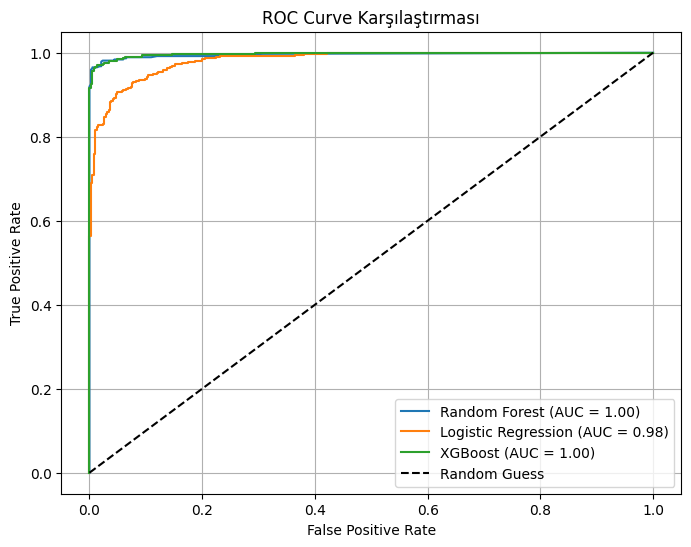

In [45]:
plt.figure(figsize=(8, 6))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Karşılaştırması')
plt.legend(loc='lower right')
plt.grid()
plt.show()


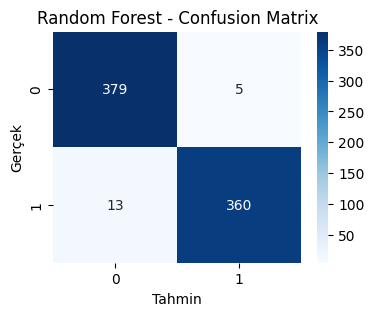

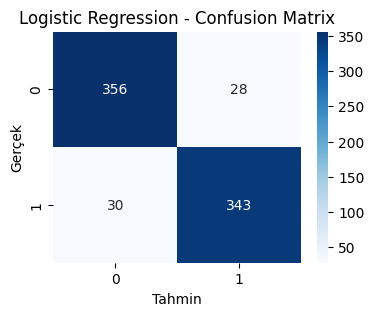

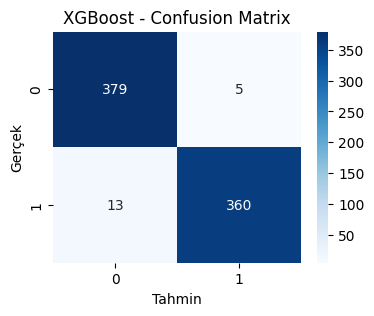

In [46]:
from sklearn.metrics import confusion_matrix

model_names = ['Random Forest', 'Logistic Regression', 'XGBoost']
y_preds = [y_pred_rf, y_pred_lr, y_pred_xgb]

for name, y_pred in zip(model_names, y_preds):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.show()


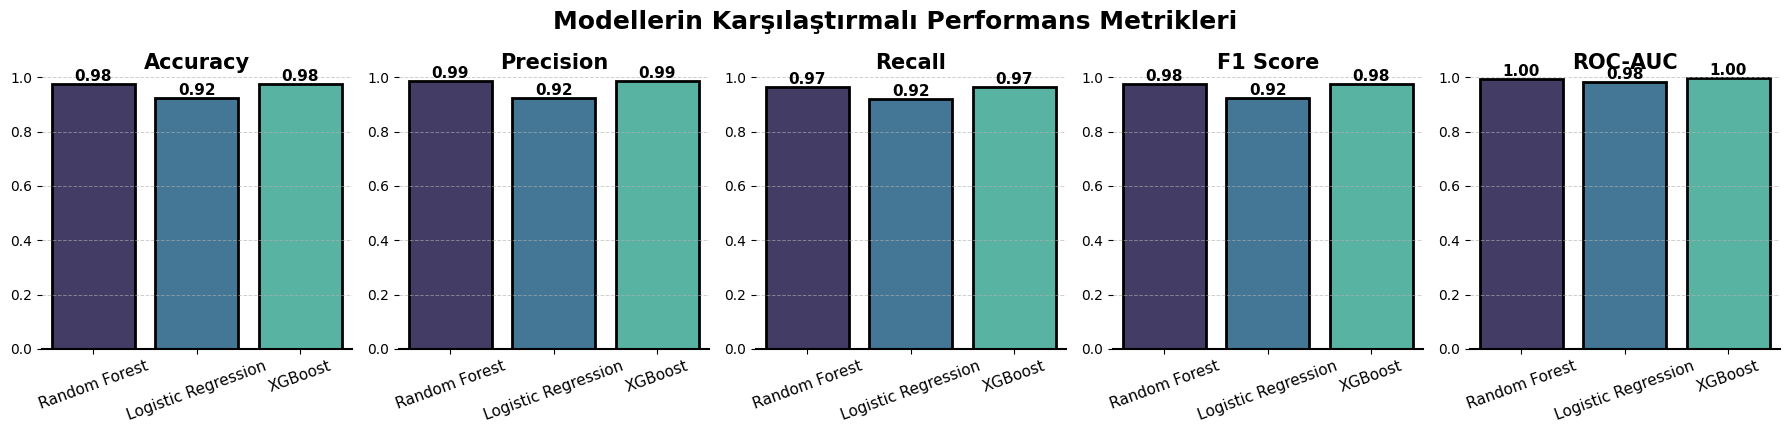

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
palette = sns.color_palette("mako", len(results_df))  # Güzel bir renk paleti

plt.figure(figsize=(18, 4))

for idx, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), idx+1)
    ax = sns.barplot(
        x="Model",
        y=metric,
        data=results_df,
        palette=palette,
        edgecolor="black",
        linewidth=2
    )
    plt.title(metric, fontsize=15, fontweight='bold')
    plt.ylim(0, 1)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=20, fontsize=11)
    # Barların üstüne değer etiketi ekle
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold',
            color='black'
        )
    # Kenarlık ve gridleri sadeleştir
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.suptitle("Modellerin Karşılaştırmalı Performans Metrikleri", y=1.07, fontsize=18, fontweight="bold")
plt.show()


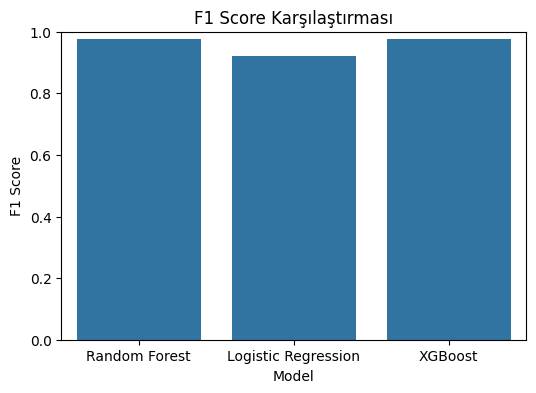

In [48]:
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="F1 Score", data=results_df)
plt.title("F1 Score Karşılaştırması")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Modeli kur
dl_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Derleme
dl_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Eğitimi başlat
history = dl_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6357 - loss: 0.6463 - precision_1: 0.6120 - recall_1: 0.7307 - val_accuracy: 0.8876 - val_loss: 0.4351 - val_precision_1: 0.9480 - val_recall_1: 0.8252
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8506 - loss: 0.4089 - precision_1: 0.8906 - recall_1: 0.7966 - val_accuracy: 0.9190 - val_loss: 0.2437 - val_precision_1: 0.9745 - val_recall_1: 0.8641
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9021 - loss: 0.2614 - precision_1: 0.9331 - recall_1: 0.8602 - val_accuracy: 0.9306 - val_loss: 0.1824 - val_precision_1: 0.9684 - val_recall_1: 0.8932
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9031 - loss: 0.2285 - precision_1: 0.9214 - recall_1: 0.8827 - val_accuracy: 0.9438 - val_loss: 0.1639 - val_precision_1: 0.9661 - val_recall_1: 0.9223
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9067 - loss: 0.2245 - precision_1: 0.9224 - recall_1: 0.8876 - val_

In [50]:
# Test verisinde tahmin yap
y_pred_dl_proba = dl_model.predict(X_test).flatten()
y_pred_dl = (y_pred_dl_proba > 0.5).astype(int)

# Metrikleri hesapla
dl_acc = accuracy_score(y_test, y_pred_dl)
dl_prec = precision_score(y_test, y_pred_dl)
dl_rec = recall_score(y_test, y_pred_dl)
dl_f1 = f1_score(y_test, y_pred_dl)
dl_auc = roc_auc_score(y_test, y_pred_dl_proba)

print("Dense Neural Network Scores:")
print(f"Accuracy: {dl_acc:.3f}")
print(f"Precision: {dl_prec:.3f}")
print(f"Recall: {dl_rec:.3f}")
print(f"F1 Score: {dl_f1:.3f}")
print(f"ROC-AUC: {dl_auc:.3f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Dense Neural Network Scores:
Accuracy: 0.950
Precision: 0.964
Recall: 0.933
F1 Score: 0.948
ROC-AUC: 0.988


In [51]:
import pandas as pd

# Eklenecek satırı DataFrame olarak oluştur
new_row = pd.DataFrame([{
    "Model": "Dense Neural Network",
    "Accuracy": dl_acc,
    "Precision": dl_prec,
    "Recall": dl_rec,
    "F1 Score": dl_f1,
    "ROC-AUC": dl_auc
}])

# Sonra concat ile birleştir
results_df = pd.concat([results_df, new_row], ignore_index=True)

print("Tüm Modellerin Karşılaştırma Tablosu:\n")
print(results_df)


Tüm Modellerin Karşılaştırma Tablosu:

                  Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0         Random Forest  0.976222   0.986301  0.965147  0.975610  0.995622
1   Logistic Regression  0.923382   0.924528  0.919571  0.922043  0.981959
2               XGBoost  0.976222   0.986301  0.965147  0.975610  0.997214
3  Dense Neural Network  0.949802   0.963989  0.932976  0.948229  0.988466


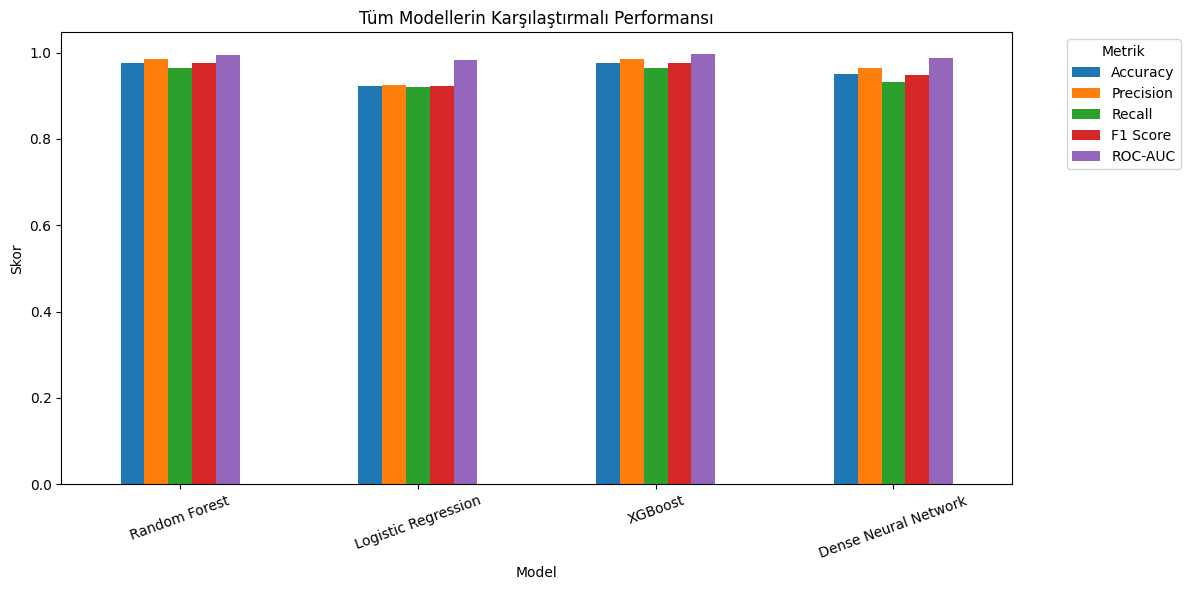

In [52]:
import matplotlib.pyplot as plt

# Model sütununu index yapalım
results_plot = results_df.set_index("Model")

# Tüm metrikleri tek grafikte çizelim (her model için tüm metrikler)
ax = results_plot.plot(kind="bar", figsize=(12, 6))

plt.title("Tüm Modellerin Karşılaştırmalı Performansı")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.xticks(rotation=20)
plt.legend(title="Metrik", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


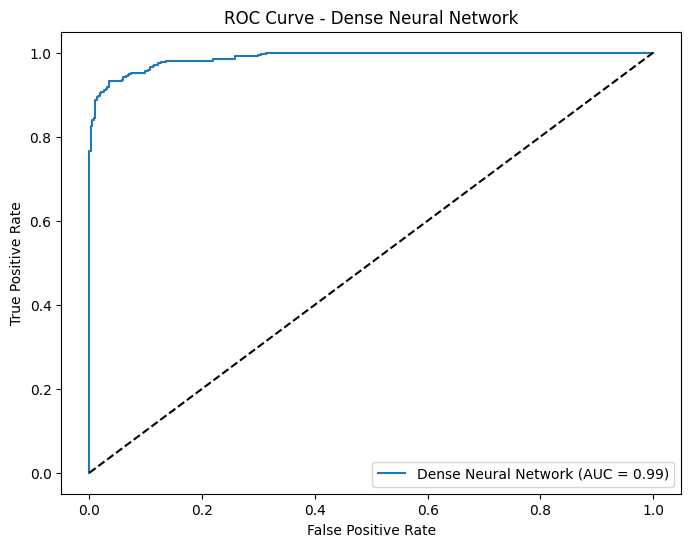

In [53]:
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_pred_dl_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr_dl, tpr_dl, label=f'Dense Neural Network (AUC = {dl_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Dense Neural Network")
plt.legend()
plt.show()


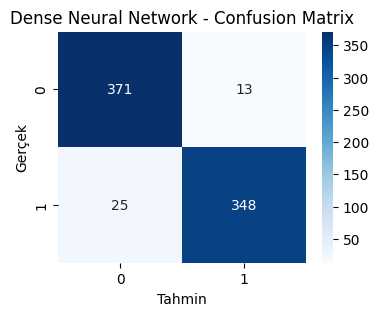

In [54]:
cm_dl = confusion_matrix(y_test, y_pred_dl)
plt.figure(figsize=(4,3))
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Blues")
plt.title("Dense Neural Network - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()


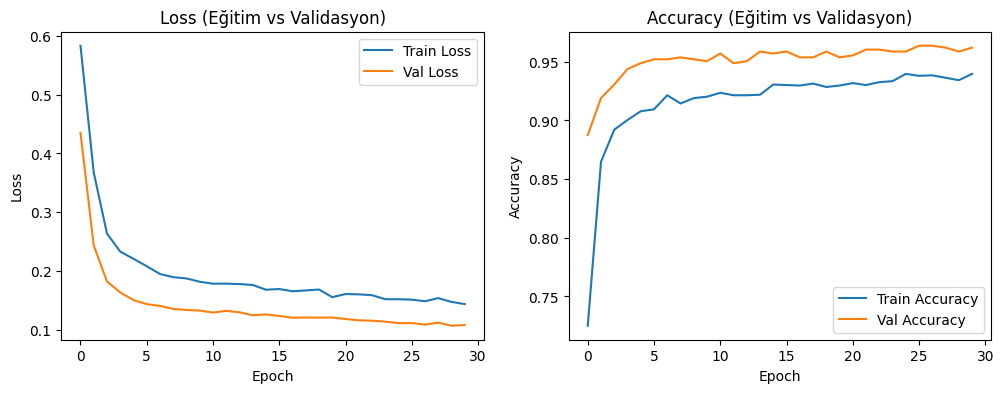

In [55]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (Eğitim vs Validasyon)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy (Eğitim vs Validasyon)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


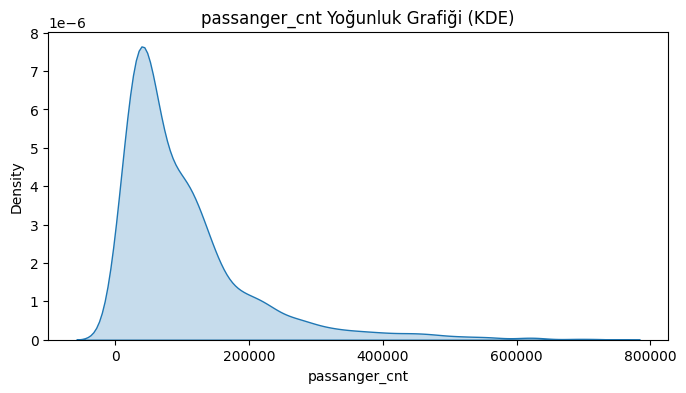

In [56]:
plt.figure(figsize=(8,4))
sns.kdeplot(df["passanger_cnt"], fill=True)
plt.title("passanger_cnt Yoğunluk Grafiği (KDE)")
plt.xlabel("passanger_cnt")
plt.show()


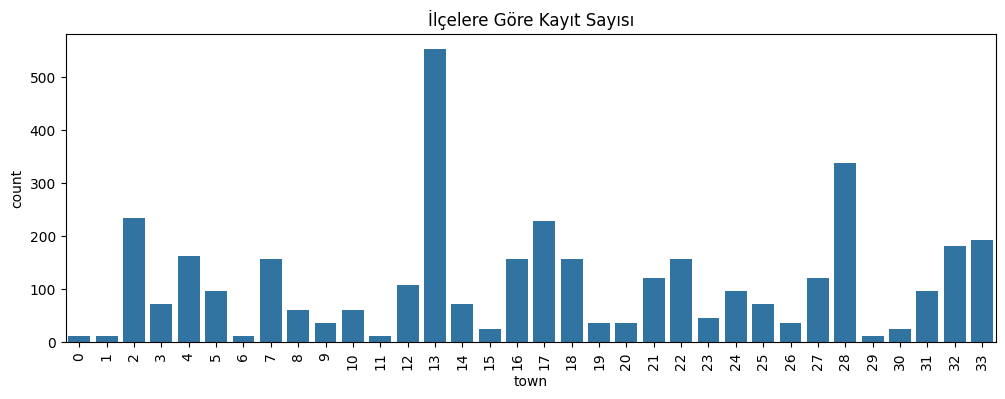

In [57]:
plt.figure(figsize=(12,4))
sns.countplot(x="town", data=df)
plt.xticks(rotation=90)
plt.title("İlçelere Göre Kayıt Sayısı")
plt.show()


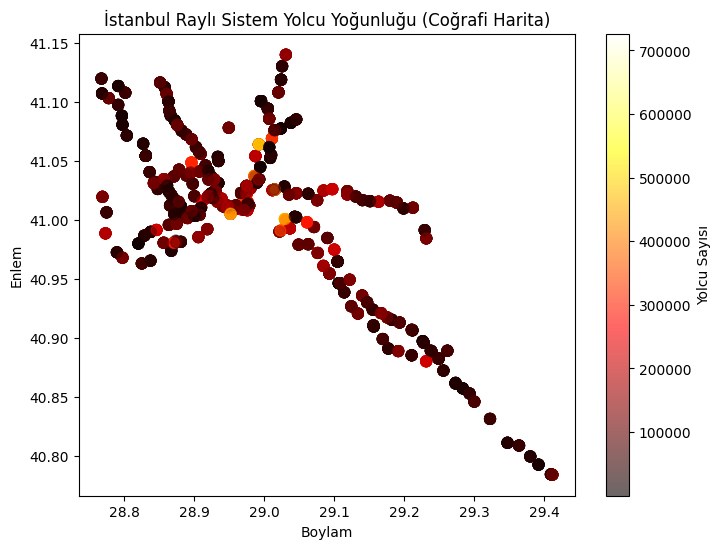

In [58]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df["longitude"], df["latitude"], c=df["passanger_cnt"], cmap="hot", alpha=0.6, s=60)
plt.colorbar(sc, label="Yolcu Sayısı")
plt.title("İstanbul Raylı Sistem Yolcu Yoğunluğu (Coğrafi Harita)")
plt.xlabel("Boylam")
plt.ylabel("Enlem")
plt.show()


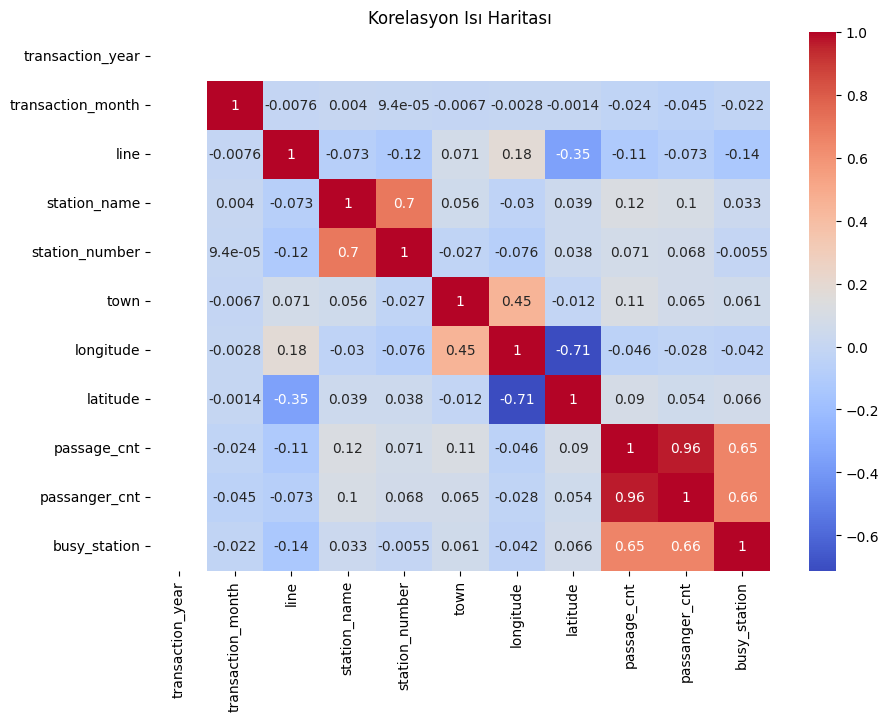

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Korelasyon Isı Haritası")
plt.show()



In [60]:
import plotly.express as px

# 1. Hiyerarşik grafikte kullanılacak tüm kategorik sütunlarda NaN varsa at:
df_sun = df.dropna(subset=['line', 'town', 'station_name', 'passanger_cnt'])

# 2. Sunburst (Hat → İlçe → İstasyon)
fig = px.sunburst(
    df_sun,
    path=['line', 'town', 'station_name'],
    values='passanger_cnt',
    title='Hat → İlçe → İstasyonlara Göre Yolcu Payı'
)
fig.show()

# 3. Treemap (Hat → İstasyon)
fig2 = px.treemap(
    df_sun,
    path=['line', 'station_name'],
    values='passanger_cnt',
    title='Hat ve İstasyonlara Göre Yolcu Payı'
)
fig2.show()


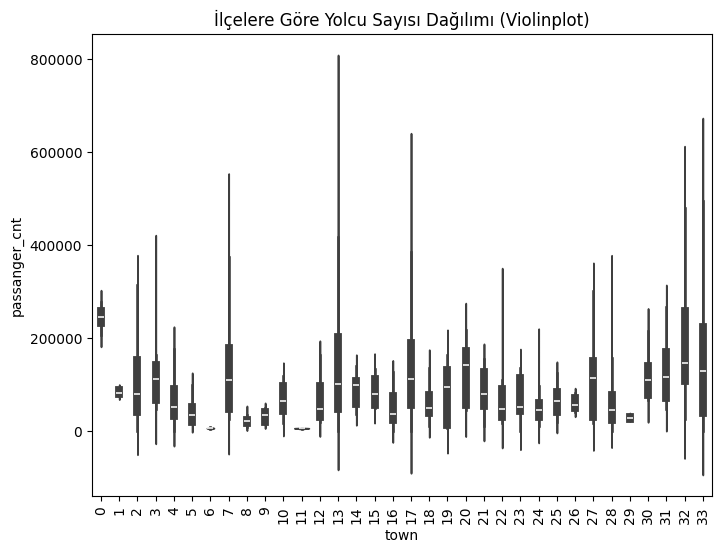

In [61]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.violinplot(x="town", y="passanger_cnt", data=df)
plt.xticks(rotation=90)
plt.title("İlçelere Göre Yolcu Sayısı Dağılımı (Violinplot)")
plt.show()


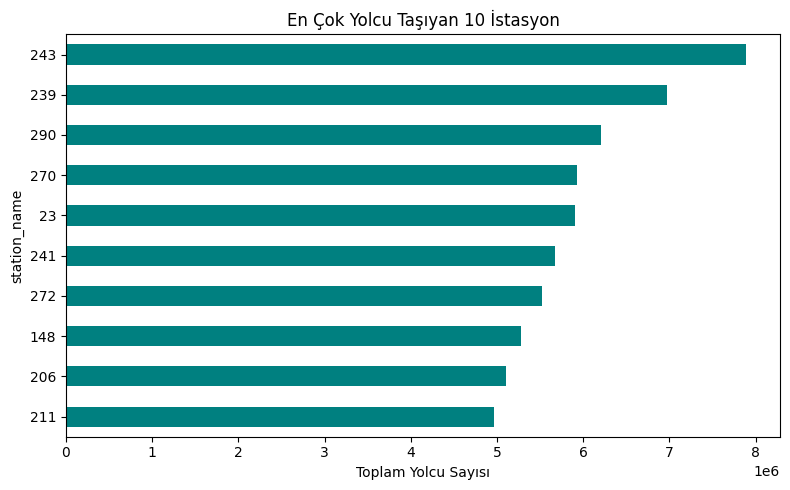

In [62]:
top_stations = df.groupby("station_name")["passanger_cnt"].sum().sort_values(ascending=False).head(10)
top_stations.plot(kind='barh', figsize=(8,5), color='teal')
plt.title("En Çok Yolcu Taşıyan 10 İstasyon")
plt.xlabel("Toplam Yolcu Sayısı")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


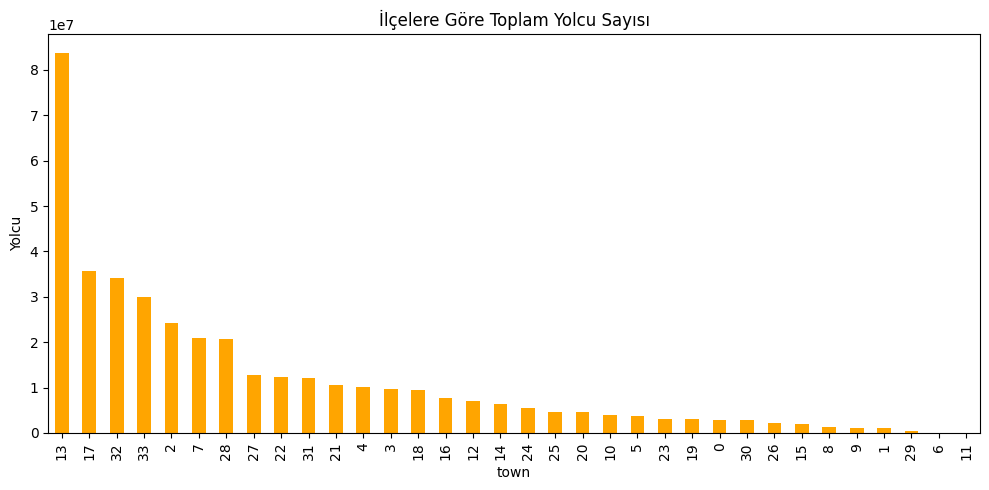

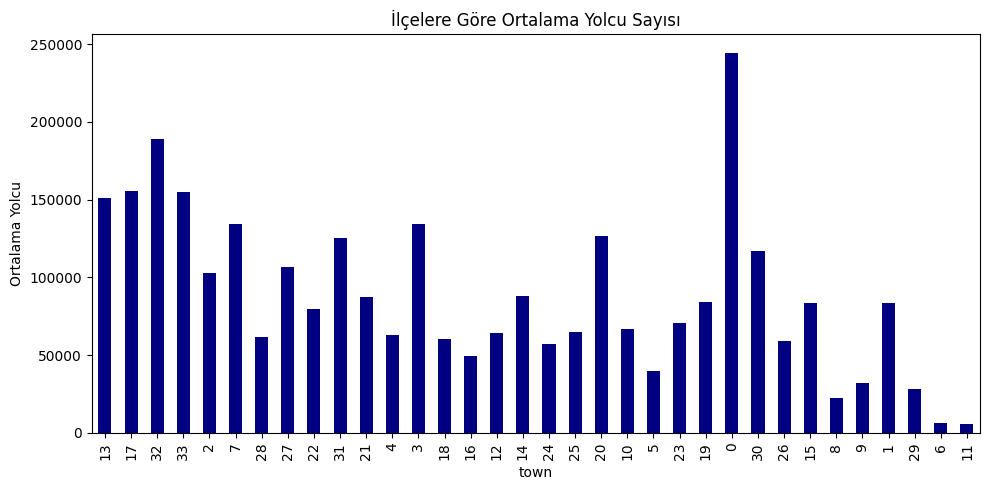

In [63]:
town_stats = df.groupby("town")["passanger_cnt"].agg(["sum", "mean"]).sort_values("sum", ascending=False)
town_stats["sum"].plot(kind='bar', figsize=(10,5), color='orange')
plt.title("İlçelere Göre Toplam Yolcu Sayısı")
plt.ylabel("Yolcu")
plt.tight_layout()
plt.show()

town_stats["mean"].plot(kind='bar', figsize=(10,5), color='navy')
plt.title("İlçelere Göre Ortalama Yolcu Sayısı")
plt.ylabel("Ortalama Yolcu")
plt.tight_layout()
plt.show()


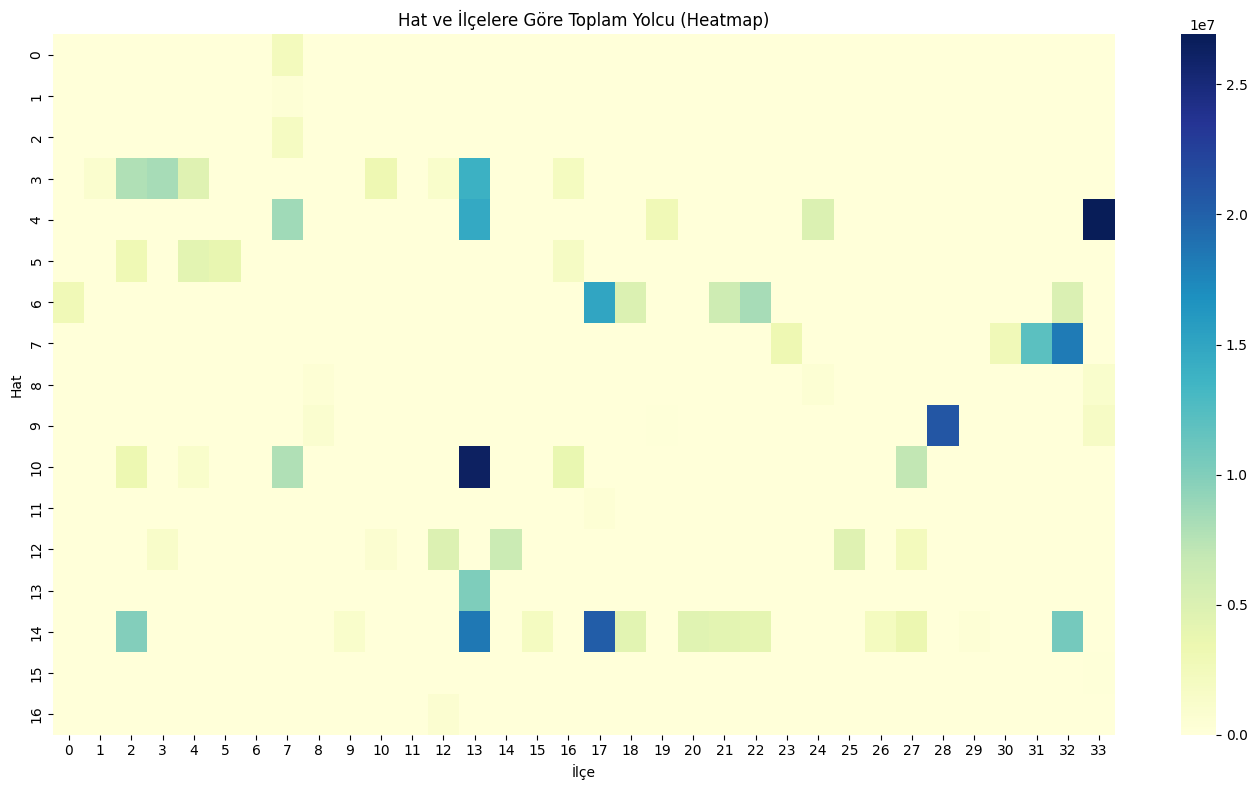

In [64]:
pivot = pd.pivot_table(df, values='passanger_cnt', index='line', columns='town', aggfunc='sum', fill_value=0)
plt.figure(figsize=(14,8))
sns.heatmap(pivot, annot=False, cmap='YlGnBu')
plt.title("Hat ve İlçelere Göre Toplam Yolcu (Heatmap)")
plt.xlabel("İlçe")
plt.ylabel("Hat")
plt.tight_layout()
plt.show()
